In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [18]:
df = pd.read_csv('HeartDiseaseTrain-Test.csv')

In [19]:
print("Dataset shape:", df.shape)
print(df.head())
print(df["target"].value_counts())
print(df.columns)

Dataset shape: (1025, 14)
   age     sex chest_pain_type  resting_blood_pressure  cholestoral  \
0   52    Male  Typical angina                     125          212   
1   53    Male  Typical angina                     140          203   
2   70    Male  Typical angina                     145          174   
3   61    Male  Typical angina                     148          203   
4   62  Female  Typical angina                     138          294   

      fasting_blood_sugar               rest_ecg  Max_heart_rate  \
0    Lower than 120 mg/ml  ST-T wave abnormality             168   
1  Greater than 120 mg/ml                 Normal             155   
2    Lower than 120 mg/ml  ST-T wave abnormality             125   
3    Lower than 120 mg/ml  ST-T wave abnormality             161   
4  Greater than 120 mg/ml  ST-T wave abnormality             106   

  exercise_induced_angina  oldpeak        slope vessels_colored_by_flourosopy  \
0                      No      1.0  Downsloping          

In [20]:
categorical_columns = ['chest_pain_type', 'rest_ecg', 'slope', 'thalassemia', 'sex', 'exercise_induced_angina']
numerical_columns = ['age', 'resting_blood_pressure', 'cholestoral', 'Max_heart_rate', 'oldpeak']

In [21]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(sparse_output=False, drop='first'), categorical_columns),  # One-hot encode categorical features, and drop one to avoid multicollinearity
    ])

In [22]:
X = df.drop("target", axis=1)
y = df["target"]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [24]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Sequential([
        Dense(64, activation='relu', input_shape=(preprocessor.fit_transform(X_train).shape[1],)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification
    ]))
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
pipeline.named_steps['model'].compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
history = pipeline.named_steps['model'].fit(preprocessor.fit_transform(X_train), y_train, epochs=50, batch_size=16,validation_split=0.1, verbose=1)

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6184 - loss: 0.6623 - val_accuracy: 0.7073 - val_loss: 0.5659
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7760 - loss: 0.4901 - val_accuracy: 0.7317 - val_loss: 0.5112
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8326 - loss: 0.3962 - val_accuracy: 0.7805 - val_loss: 0.4880
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8723 - loss: 0.3466 - val_accuracy: 0.7683 - val_loss: 0.4655
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8602 - loss: 0.3623 - val_accuracy: 0.7805 - val_loss: 0.4644
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8433 - loss: 0.3441 - val_accuracy: 0.7927 - val_loss: 0.4798
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8452 - loss: 0.3293 - val_accuracy: 0.8049 - val_loss: 0.4542
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8505 - loss: 0.3390 - val_accuracy: 0.7683 - val_loss:

In [27]:
y_pred_prob = pipeline.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [28]:
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n📄 Classification Report:\n", classification_report(y_test, y_pred))

✅ Accuracy: 0.9121951219512195

📊 Confusion Matrix:
 [[92  8]
 [10 95]]

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91       100
           1       0.92      0.90      0.91       105

    accuracy                           0.91       205
   macro avg       0.91      0.91      0.91       205
weighted avg       0.91      0.91      0.91       205



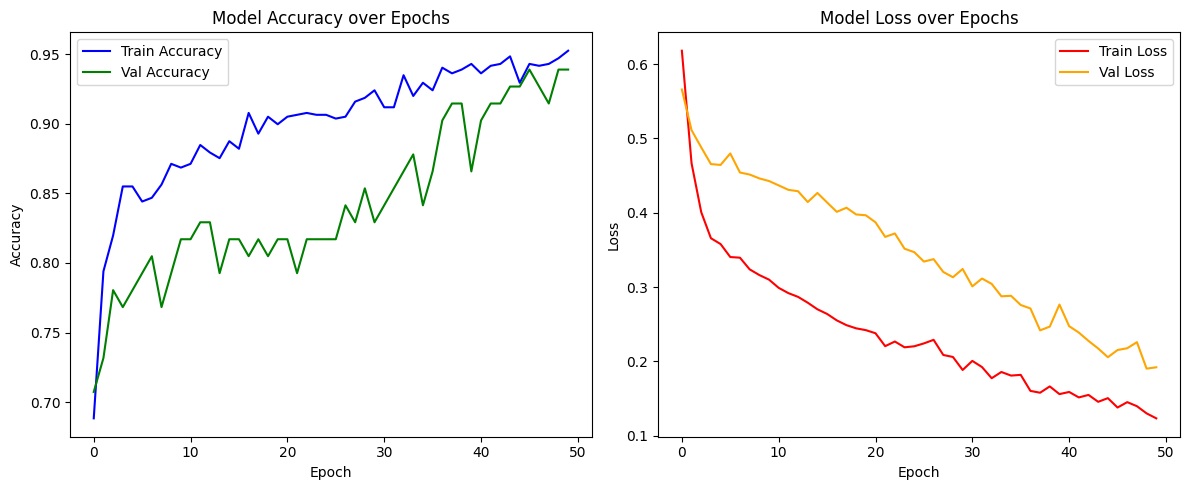

In [29]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='green')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='red')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()